# <span style="color:blue"> Enhancing Public Transit Forecasting: Machine Learning Applications to MRT-3 Ridership</span>
**Beatrice Elaine Banzon, Angelo Gaillard Endozo, Charles Mathew Ong** <br>
DATA103 - S11 

# <span style="color:blue"> I. Introduction of Problem</span>

## 1.1 The Problem
More than 59% of the Philippines’ population rely on public transportation in 2023 (Balita, 2024) given their accessibility and affordability. Traffic congestion becomes worst concurrent with the continued increases in the demand for public transportation (Ganiron, 2015). There have been concerns about the Metro Rail Transit's (MRT-3) capacity to address the demand given the supply of trains and services. Thus, estimation of the number of entry passengers may aid in the improvement in operations related to crowd regulation, train regulation system, and developments in the trains' capacity (supply) (Deplomo, Villaberde, & Paglinawan, 2021). Short-term forecasting allows for better day to day decisions on the supply of trains (Tsai, Lee, & Wei, 2009), further aiding long-term capacity adjustments.

To enable the prediction, datasets on the entry and exit of passengers in MRT-3 have been requested via FOI. The link of the datasets may be found in: https://drive.google.com/drive/folders/1AfF4ZzCLh9CJrffsxCLF12ZBnZm50ufv?usp=sharing

## 1.2 Features of the Initial Dataset
1. Date [Day, Month DD, YYYY]
2. Time [XX:XX - XX:XX]
3. Stations [North Ave, Quezon Ave, GMA Kamuning, Cubao, Santolan, Ortigas, Shaw Blvd, Boni Ave, Guadalupe, Buendia, Ayala Ave, Magallanes, Taft]
4. Entry [Numerical] (Target) - number of passengers entering the station
5. Exit [Numerical] - number of passengers exiting the station

# <span style="color:blue"> II. List of Requirements </span>

## 2.1 Libraries

In [2]:
# Data Management Packages
import pandas as pd
import numpy as np
from collections import Counter

# Data Preprocessing Package
from sklearn.impute import KNNImputer

# Data Visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns

# Plotly Customization
template = "plotly_white"
px.defaults.template = "plotly_white"
color_discrete_sequence = px.colors.qualitative.Safe

# File system package
from os import listdir

from sklearn.model_selection import GridSearchCV

## 2.2 Opening the Obtained Datasets

The datasets from FOI were in xlsx format, with tables in each file. Those were converted into a CSV file.

The conversion appears to be succesful but there are caveats:
1. February 2019 xlsx was corrupted and not converted.
2. There are days with entirely 0 entry & exit records.
3. The records contain all days present only within said month. 31st and February leap days are excluded.

In [4]:
def read_CSV_in_years(YEARS = ('2019', '2020', '2021', '2022', '2023')):
    '''
    Parameters
    -----------
    YEARS        : Years to include/open.

    Parameters
    -----------
    Opens all the MRT train csv files within the provided years.
    Call cleanCSV() to open, clean, and return a dataframe.

    Return   
    ------------
    pd.Dataframe : All the cleaned CSVs compiled into a single dataframe.
    '''
    compiled_df = []
    FILES = listdir('MTR Parsed')

    # OPEN AND STORE ALL THE TARGET CSV FILES
    for fileName in FILES:
        if fileName[-4:] == '.csv' and fileName[:4] in YEARS:
            compiled_df.append(clean_CSV(fileName))
    
    return pd.concat(compiled_df)

In [6]:
def clean_CSV(fileName, min_traffic_threshold = 0):
    '''
    Parameters
    -----------
    fileName               : String name of the .csv file.
    min_traffic_threshold  : Stations records with daily traffic below the threshold will be dropped.

    Parameters
    -----------
    Open the csv file and drop all records of stations with little/no activity for the entire day.

    Return   
    ------------
    pd.Dataframe : The cleaned csv data.
    '''
    df = pd.read_csv('MTR Parsed/' + fileName)
    # REMOVE INDEX COL
    df = df.drop(df.columns[0], axis=1)

    # CHECK THE TRAFFIC ACTIVITY OF PER STATION EVERYDAY 
    '''
    activity_check = df[['Day', 'Station_No', 'Net_Traffic']]
    activity_check = activity_check.groupby(['Day', 'Station_No']).sum()
    
    # KEEP ONLY THE STATION RECORDS THAT HAD ACTIVITY FOR THAT DAY
    records_to_keep = activity_check[activity_check.values > min_traffic_threshold]
    df = df.set_index(['Day', 'Station_No']).join(records_to_keep, lsuffix='' , rsuffix='_ActivityCheck')
    df = df.dropna(axis=0)
    df = df.rename(columns={df.columns[-1]:'Station_Total_Day_Traffic'})
    '''
    
    df['Date'] = pd.to_datetime(df['Date'])
    # df = df.reset_index()
    
    return df

In [8]:
main_df = read_CSV_in_years()
main_df.head()

Date           Time  Station_Name  Station_No  Entry  Exit  \
0 2022-02-01  03:00 - 03:59     North Ave           0      0   0.0   
1 2022-02-01  03:00 - 03:59    Quezon Ave           1      0   0.0   
2 2022-02-01  03:00 - 03:59  GMA Kamuning           2      0   0.0   
3 2022-02-01  03:00 - 03:59         Cubao           3      0   0.0   
4 2022-02-01  03:00 - 03:59      Santolan           4      0   0.0   

   Net_Traffic  Year  Month  Day  Hour  Weekday  Is_Holiday  
0          0.0  2022      2    1     3        1        True  
1          0.0  2022      2    1     3        1        True  
2          0.0  2022      2    1     3        1        True  
3          0.0  2022      2    1     3        1        True  
4          0.0  2022      2    1     3        1        True

## 2.3 General Checks

In [11]:
main_df.shape

(531089, 13)

In [13]:
main_df.isnull().sum()

Date            0
Time            0
Station_Name    0
Station_No      0
Entry           0
Exit            0
Net_Traffic     0
Year            0
Month           0
Day             0
Hour            0
Weekday         0
Is_Holiday      0
dtype: int64

In [15]:
main_df.dtypes

Date            datetime64[ns]
Time                    object
Station_Name            object
Station_No               int64
Entry                    int64
Exit                   float64
Net_Traffic            float64
Year                     int64
Month                    int64
Day                      int64
Hour                     int64
Weekday                  int64
Is_Holiday                bool
dtype: object

In [17]:
composition = main_df.groupby('Year').count()
composition['Percentage'] = composition.iloc[:, 0] / composition.iloc[:, 0].sum()
composition.rename(columns={composition.columns[0]: "Number of Data Points"}, inplace=True)
composition[['Number of Data Points', 'Percentage']]

Number of Data Points  Percentage
Year                                   
2019                 105144    0.197978
2020                  84305    0.158740
2021                 113880    0.214427
2022                 113880    0.214427
2023                 113880    0.214427

In [19]:
check = ['Exit', 'Entry']
main_df[check].describe()

Exit          Entry
count  531089.000000  531089.000000
mean      574.666163     576.217609
std       853.122014     856.970677
min         0.000000       0.000000
25%         0.000000       0.000000
50%       144.000000     142.000000
75%       897.000000     903.000000
max      7333.000000    7445.000000

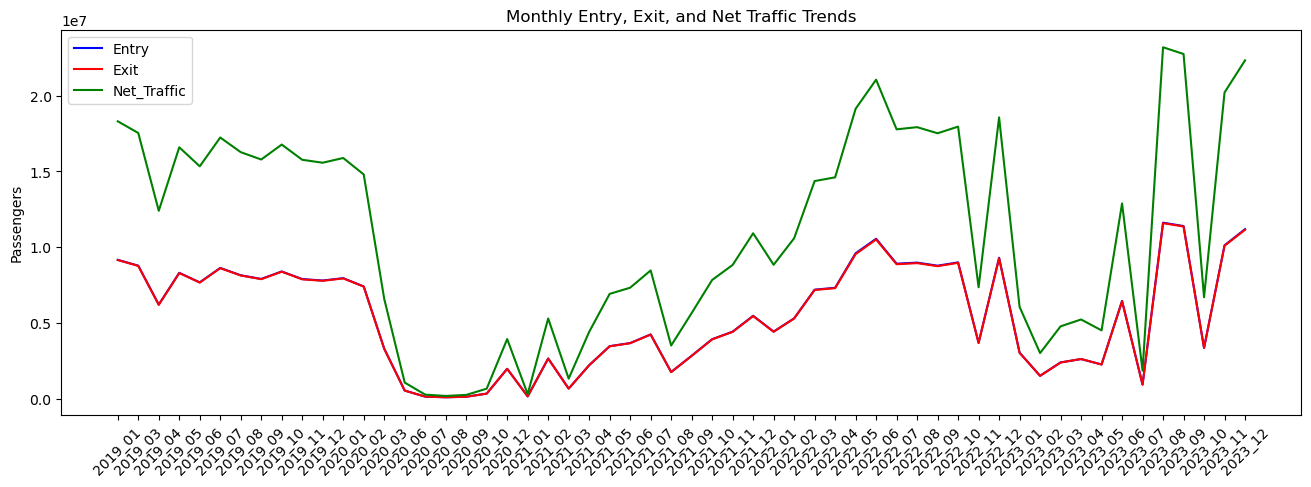

In [21]:
main_df['Year_Month'] = main_df['Year'].astype(str) + '_' + main_df['Month'].astype(str).str.zfill(2)
plot_df = main_df[['Entry', 'Exit','Net_Traffic', 'Year_Month']].groupby('Year_Month').sum()

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(plot_df.index, plot_df['Entry'], label='Entry', color='blue')
ax.plot(plot_df.index, plot_df['Exit'], label='Exit', color='red')
ax.plot(plot_df.index, plot_df['Net_Traffic'], label='Net_Traffic', color='green')

ax.set_title("Monthly Entry, Exit, and Net Traffic Trends")
ax.set_ylabel("Passengers")

ticks = plot_df.index
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)

ax.legend()
plt.show()

# <span style="color:blue"> III. Data Preprocessing and Cleaning</span>

## 3.1 Dropping Variables
The following variables are dropped: Time, Exit, and Station Name.

1. Time: In the obtained dataset, hour was already added as a column for ease of use in modelling.
2. Exit: MRT has disclosed that Exit values are incomplete. Entry and exit values are imbalanced.
3. Station_Name: Each station has been assigned a number instead.

In [24]:
df = main_df.copy(deep=True)
df.head()

Date           Time  Station_Name  Station_No  Entry  Exit  \
0 2022-02-01  03:00 - 03:59     North Ave           0      0   0.0   
1 2022-02-01  03:00 - 03:59    Quezon Ave           1      0   0.0   
2 2022-02-01  03:00 - 03:59  GMA Kamuning           2      0   0.0   
3 2022-02-01  03:00 - 03:59         Cubao           3      0   0.0   
4 2022-02-01  03:00 - 03:59      Santolan           4      0   0.0   

   Net_Traffic  Year  Month  Day  Hour  Weekday  Is_Holiday Year_Month  
0          0.0  2022      2    1     3        1        True    2022_02  
1          0.0  2022      2    1     3        1        True    2022_02  
2          0.0  2022      2    1     3        1        True    2022_02  
3          0.0  2022      2    1     3        1        True    2022_02  
4          0.0  2022      2    1     3        1        True    2022_02

In [27]:
drop = ['Exit', 'Station_No','Net_Traffic']
df.drop(columns=drop, inplace=True)
df

Date           Time  Station_Name  Entry  Year  Month  Day  Hour  \
0    2022-02-01  03:00 - 03:59     North Ave      0  2022      2    1     3   
1    2022-02-01  03:00 - 03:59    Quezon Ave      0  2022      2    1     3   
2    2022-02-01  03:00 - 03:59  GMA Kamuning      0  2022      2    1     3   
3    2022-02-01  03:00 - 03:59         Cubao      0  2022      2    1     3   
4    2022-02-01  03:00 - 03:59      Santolan      0  2022      2    1     3   
...         ...            ...           ...    ...   ...    ...  ...   ...   
9667 2019-03-31  02:00 - 02:59     Guadalupe      0  2019      3   31     2   
9668 2019-03-31  02:00 - 02:59       Buendia      0  2019      3   31     2   
9669 2019-03-31  02:00 - 02:59     Ayala Ave      0  2019      3   31     2   
9670 2019-03-31  02:00 - 02:59    Magallanes      0  2019      3   31     2   
9671 2019-03-31  02:00 - 02:59          Taft      0  2019      3   31     2   

      Weekday  Is_Holiday Year_Month  
0           1        True    2022_02  
1           1        True    2022_02  
2           1        True    2022_02  
3           1        True    2022_02  
4           1        True    2022_02  
...       ...         ...        ...  
9667        6       False    2019_03  
9668        6       False    2019_03  
9669        6       False    2019_03  
9670        6       False    2019_03  
9671        6       False    2019_03  

[531089 rows x 11 columns]

## 3.2 Data Transformation

In [30]:
df['Is_Holiday'] = df.Is_Holiday.astype('int')
df['Weekday'] += 1

In [32]:
# Optimizing Formats
    ## Safe to lower the int64 and float64 formats. They are within int16 range and entry rate are whole numbers.
    ## This reduces memory usage from original 67.3 MB to ~35MB

convertCols = df.select_dtypes(['int', 'float']).columns
df[convertCols].max()

for col in convertCols:
    if df[col].max() <= 127:
        df[col] = df[col].astype('int8')
    elif df[col].max() <= 32767:
        df[col] = df[col].astype('int16')
    else:
        print(f"{col} data out of range")
        assert False
        
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531089 entries, 0 to 9671
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          531089 non-null  datetime64[ns]
 1   Time          531089 non-null  object        
 2   Station_Name  531089 non-null  object        
 3   Entry         531089 non-null  int16         
 4   Year          531089 non-null  int16         
 5   Month         531089 non-null  int8          
 6   Day           531089 non-null  int8          
 7   Hour          531089 non-null  int8          
 8   Weekday       531089 non-null  int8          
 9   Is_Holiday    531089 non-null  int8          
 10  Year_Month    531089 non-null  object        
dtypes: datetime64[ns](1), int16(2), int8(5), object(3)
memory usage: 24.8+ MB


## 3.3. Splicing the DataFrame
The initial dataset contains data points from January 2019 to December 2023; however, the timeframe chosen for this project only spans from April 18, 2022 to December 31, 2023.

In [35]:
# The timeframe that was chosen was from April 18, 2022 to December 31, 2023, because this timeframe exemplified a more stable entry volume of passengers post-COVID.

# Store post-COVID data from April 18, 2022 to December 31, 2023 from 4 am to 11pm (operational hours of MRT)
df_splice = df[(df.Date >= '2022-04-18') & ~(df.Hour.between(0,3))].copy()
df_splice = df_splice.reset_index().drop(columns='index')
df_splice.head()

Date           Time  Station_Name  Entry  Year  Month  Day  Hour  \
0 2023-03-01  04:00 - 04:59     North Ave    594  2023      3    1     4   
1 2023-03-01  04:00 - 04:59    Quezon Ave    386  2023      3    1     4   
2 2023-03-01  04:00 - 04:59  GMA Kamuning    771  2023      3    1     4   
3 2023-03-01  04:00 - 04:59         Cubao    583  2023      3    1     4   
4 2023-03-01  04:00 - 04:59      Santolan     21  2023      3    1     4   

   Weekday  Is_Holiday Year_Month  
0        3           0    2023_03  
1        3           0    2023_03  
2        3           0    2023_03  
3        3           0    2023_03  
4        3           0    2023_03

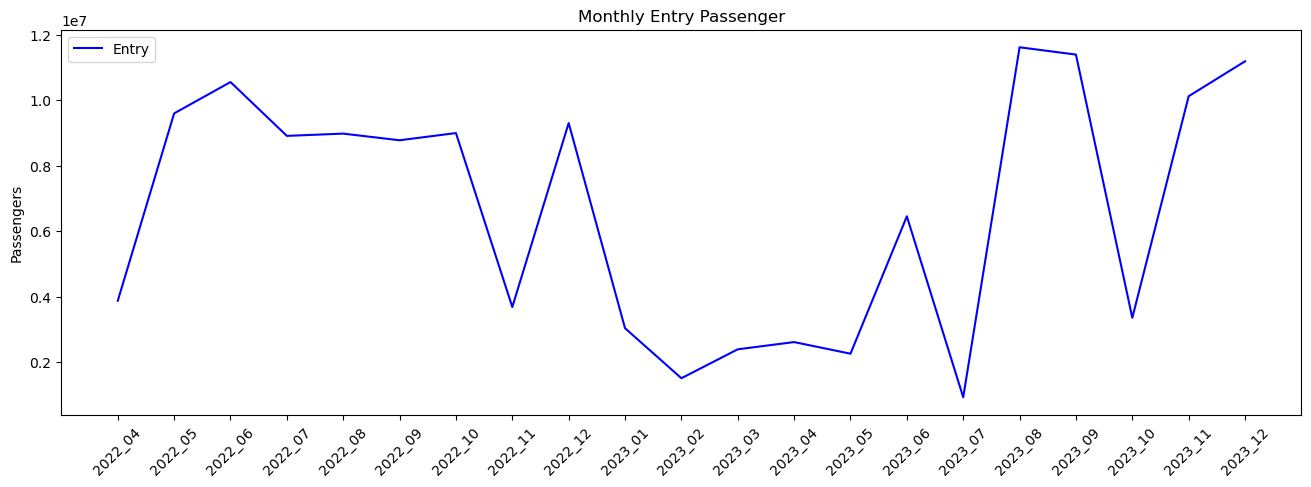

In [37]:
plot_df = df_splice[['Entry','Year_Month']].groupby('Year_Month').sum()

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(plot_df.index, plot_df['Entry'], label='Entry', color='blue')

ax.set_title("Monthly Entry Passenger")
ax.set_ylabel("Passengers")

ticks = plot_df.index
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, rotation=45)

ax.legend()
plt.show()

df_splice.drop(columns=['Year_Month'], inplace=True)

In [39]:
# Creating a disposable column to store integer Hour values
df_splice['Hour_delta'] = df_splice.Hour

# Converting the integer Hour values to timedelta format e.g. from 4 to 04:00:00
df_splice['Hour_delta'] = pd.to_timedelta(df_splice.Hour_delta, unit='h')

# Create Date_Time column to store the concatenated Date datetime values and Hour timedelta values
df_splice['Date_Time'] = df_splice.Date + df_splice.Hour_delta

# Rename the dataframe to df_ridership after creating a copy
df_ridership = df_splice.copy(deep=True)

# Drop redundant columns
df_ridership = df_ridership.drop(['Date', 'Time', 'Hour_delta'], axis=1)

# Add Date_Time column as the first column and remove Date_Time column as the last column
df_ridership.insert(0, 'Date_Time', df_ridership.pop('Date_Time'))

# Set the Date_Time column as index to make the dataframe a time series data
df_ridership.set_index('Date_Time', inplace=True)

In [41]:
# Display time series DataFrame and info
display(df_ridership.head())
display(df_ridership.info())

Station_Name  Entry  Year  Month  Day  Hour  Weekday  \
Date_Time                                                                   
2023-03-01 04:00:00     North Ave    594  2023      3    1     4        3   
2023-03-01 04:00:00    Quezon Ave    386  2023      3    1     4        3   
2023-03-01 04:00:00  GMA Kamuning    771  2023      3    1     4        3   
2023-03-01 04:00:00         Cubao    583  2023      3    1     4        3   
2023-03-01 04:00:00      Santolan     21  2023      3    1     4        3   

                     Is_Holiday  
Date_Time                        
2023-03-01 04:00:00           0  
2023-03-01 04:00:00           0  
2023-03-01 04:00:00           0  
2023-03-01 04:00:00           0  
2023-03-01 04:00:00           0

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161980 entries, 2023-03-01 04:00:00 to 2023-01-31 23:00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Station_Name  161980 non-null  object
 1   Entry         161980 non-null  int16 
 2   Year          161980 non-null  int16 
 3   Month         161980 non-null  int8  
 4   Day           161980 non-null  int8  
 5   Hour          161980 non-null  int8  
 6   Weekday       161980 non-null  int8  
 7   Is_Holiday    161980 non-null  int8  
dtypes: int16(2), int8(5), object(1)
memory usage: 3.9+ MB


None

## 3.4 Imputation

#### Creating maintenance days mask and integrating NaN data
Since our data has no null values, we have to differentiate which entry instances should be zero and null. It has been identified that MRT maintenance happened from April 06 to April 09 2023, hence it is accepetable to have zero ridership in these days. On the other hand, null values must be assigned to days with zero ridership during operational hours.

In [45]:
# Sum the hourly entry volume within the day
all_stations_entry = df_ridership[['Entry']]
all_stations_daily = all_stations_entry.resample('D').sum()

# Maintenance start and end for 2023
maintenance_start_2023 = '2023-04-06'
maintenance_end_2023 = '2023-04-09'

# Create boolean masks for maintenance periods
maintenance_mask_2023 = (all_stations_daily.index >= maintenance_start_2023) & (all_stations_daily.index <= maintenance_end_2023)

# Find days with no ridership that are not in maintenance periods
no_ridership_days = all_stations_daily.index[(all_stations_daily['Entry'] == 0) & ~maintenance_mask_2023]

# From the hourly ridership DataFrame set the 0 values as NaN on days where there is no rdiership during operational hours
df_ridership.loc[df_ridership.index.normalize().isin(no_ridership_days), 'Entry'] = np.nan

In [47]:
df_ridership.isna().sum()

Station_Name        0
Entry           49660
Year                0
Month               0
Day                 0
Hour                0
Weekday             0
Is_Holiday          0
dtype: int64

In [49]:
df_ridership

Station_Name  Entry  Year  Month  Day  Hour  Weekday  \
Date_Time                                                                   
2023-03-01 04:00:00     North Ave  594.0  2023      3    1     4        3   
2023-03-01 04:00:00    Quezon Ave  386.0  2023      3    1     4        3   
2023-03-01 04:00:00  GMA Kamuning  771.0  2023      3    1     4        3   
2023-03-01 04:00:00         Cubao  583.0  2023      3    1     4        3   
2023-03-01 04:00:00      Santolan   21.0  2023      3    1     4        3   
...                           ...    ...   ...    ...  ...   ...      ...   
2023-01-31 23:00:00     Guadalupe    NaN  2023      1   31    23        2   
2023-01-31 23:00:00       Buendia    NaN  2023      1   31    23        2   
2023-01-31 23:00:00     Ayala Ave    NaN  2023      1   31    23        2   
2023-01-31 23:00:00    Magallanes    NaN  2023      1   31    23        2   
2023-01-31 23:00:00          Taft    NaN  2023      1   31    23        2   

                     Is_Holiday  
Date_Time                        
2023-03-01 04:00:00           0  
2023-03-01 04:00:00           0  
2023-03-01 04:00:00           0  
2023-03-01 04:00:00           0  
2023-03-01 04:00:00           0  
...                         ...  
2023-01-31 23:00:00           0  
2023-01-31 23:00:00           0  
2023-01-31 23:00:00           0  
2023-01-31 23:00:00           0  
2023-01-31 23:00:00           0  

[161980 rows x 8 columns]

#### KNN Imputation
Among all time series imputation methods that were tried, such as the Kalman Smoothing Imputation, Multiple Imputation by Chained Equation, KNN Imputation, Linear and Polynomial imputation, the KNN imputation exhibited the best performance in imputing the missing values of the MRT ridership data as it mimicked the hourly seasonality patterns of the data.

In [52]:
# Group data by station name
grouped_station = df_ridership.groupby('Station_Name')

# Store each station dataframe in a dictionary that can be accessed easily
station_dfs = {station: entry_data for station, entry_data in grouped_station}

In [54]:
# Initialize KNNImputer with 5 neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Dictionary to store imputed dataframes
imputed_station_dfs = {}

# Loop through each station dataframe and apply KNN Imputer
for station, df in station_dfs.items():
    # Make a copy of the dataframe
    df_copy = df.copy()
    # Drop the 'Station_Name' column
    station_name_column = df_copy.pop('Station_Name')
    # Apply KNNImputer
    imputed_data = knn_imputer.fit_transform(df_copy)
    # Store newly transformed DataFrame with imputed values in a DataFrame
    imputed_df = pd.DataFrame(data=imputed_data, columns=df_copy.columns, index=df_copy.index)
    # Add the 'Station_Name' column back to the dataframe
    imputed_df['Station_Name'] = station_name_column
    # Add the imputed dataframe to the dictionary
    imputed_station_dfs[station] = imputed_df

In [55]:
# Manually access the imputed dataframe for each station
north_ave_df = imputed_station_dfs['North Ave']
quezon_ave_df = imputed_station_dfs['Quezon Ave']
gma_kamuning_df = imputed_station_dfs['GMA Kamuning']
cubao_df = imputed_station_dfs['Cubao']
santolan_df = imputed_station_dfs['Santolan']
ortigas_df = imputed_station_dfs['Ortigas']
shaw_blvd_df = imputed_station_dfs['Shaw Blvd']
boni_ave_df = imputed_station_dfs['Boni Ave']
guadalupe_df = imputed_station_dfs['Guadalupe']
buendia_df = imputed_station_dfs['Buendia']
ayala_ave_df = imputed_station_dfs['Ayala Ave']
magallanes_df = imputed_station_dfs['Magallanes']
taft_df = imputed_station_dfs['Taft']

In [56]:
for station, df in station_dfs.items():
    Null_Values_of_Entry = df['Entry'].isnull().sum()
    print(f"{station}, Null Values: {Null_Values_of_Entry}")

Ayala Ave, Null Values: 3820
Boni Ave, Null Values: 3820
Buendia, Null Values: 3820
Cubao, Null Values: 3820
GMA Kamuning, Null Values: 3820
Guadalupe, Null Values: 3820
Magallanes, Null Values: 3820
North Ave, Null Values: 3820
Ortigas, Null Values: 3820
Quezon Ave, Null Values: 3820
Santolan, Null Values: 3820
Shaw Blvd, Null Values: 3820
Taft, Null Values: 3820


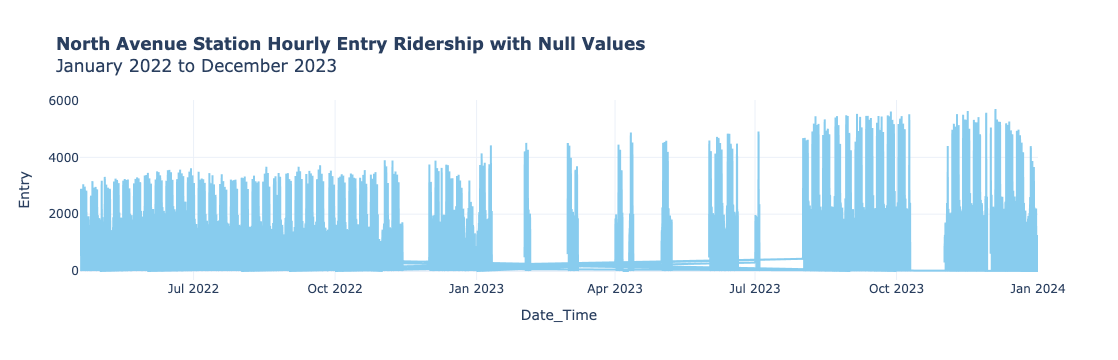

In [57]:
# Visualize the Hourly Entry Ridership with null values for North Avenue 
fig = px.line(station_dfs['North Ave'], y="Entry", title="<b>North Avenue Station Hourly Entry Ridership with Null Values</b><br>January 2022 to December 2023", color_discrete_sequence=color_discrete_sequence)

fig.show()

In [58]:
imputed_station_dfs

{'Ayala Ave':                       Entry    Year  Month   Day  Hour  Weekday  Is_Holiday  \
 Date_Time                                                                     
 2023-03-01 04:00:00    11.0  2023.0    3.0   1.0   4.0      3.0         0.0   
 2023-03-01 05:00:00   647.0  2023.0    3.0   1.0   5.0      3.0         0.0   
 2023-03-01 06:00:00  1508.0  2023.0    3.0   1.0   6.0      3.0         0.0   
 2023-03-01 07:00:00  1531.0  2023.0    3.0   1.0   7.0      3.0         0.0   
 2023-03-01 08:00:00  1319.0  2023.0    3.0   1.0   8.0      3.0         0.0   
 ...                     ...     ...    ...   ...   ...      ...         ...   
 2023-01-31 19:00:00  2575.4  2023.0    1.0  31.0  19.0      2.0         0.0   
 2023-01-31 20:00:00  2250.4  2023.0    1.0  31.0  20.0      2.0         0.0   
 2023-01-31 21:00:00  1247.8  2023.0    1.0  31.0  21.0      2.0         0.0   
 2023-01-31 22:00:00   792.2  2023.0    1.0  31.0  22.0      2.0         0.0   
 2023-01-31 23:00:00   444.

Explanation: It can be observed from the line plot that there are significant gaps in the data. We consider these entries, amounting to 3,820 instances, as null values.
b.) Line Plot of Entry Ridership with Imputed Values

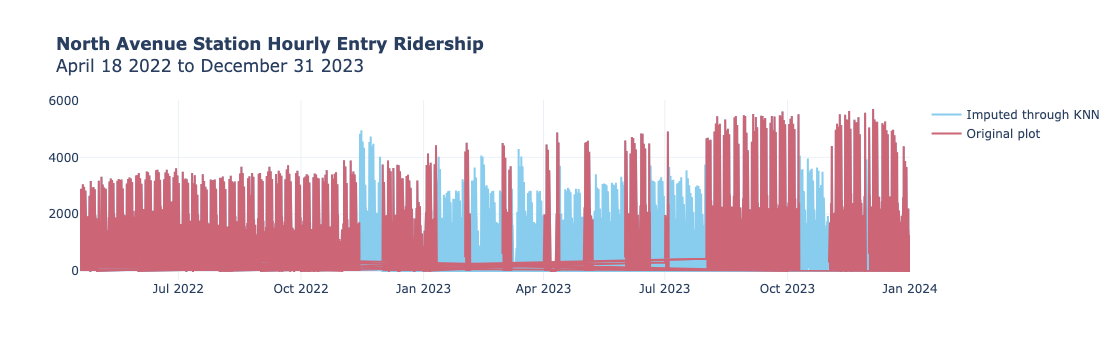

In [60]:
# Visualize the Hourly Entry Ridership with imputed values for North Avenue
# Initalize graph_objects figure
fig = go.Figure()

# Create line plot for the imputed North Avenue hourly entry ridership
fig.add_trace(go.Scatter(x=north_ave_df.index, y=north_ave_df.Entry,
                    mode='lines',
                    name='Imputed through KNN',
                    marker_color=color_discrete_sequence[0]))
# Create line plot for the original North Avenue hourly entry ridership
fig.add_trace(go.Scatter(x=station_dfs['North Ave'].index, y=station_dfs['North Ave'].Entry,
                    mode='lines',
                    name='Original plot',
                    marker_color=color_discrete_sequence[1]))
# Add title and integrate plotly template 
fig.update_layout(title="<b>North Avenue Station Hourly Entry Ridership</b><br>April 18 2022 to December 31 2023", template=template)

# Show figure
fig.show()

Explanation: Presented in the line plot is the imputed hourly entry ridership in North Avenue station. It can be observed that the behavior of the original plot is mimicked by the imputed values, which is a good indicator that the imputed values approximately follow the hourly seasonality patterns of the data. This also demonstrates that KNN imputation is an effective method for imputing wide gaps in time series data.

## 3.5 Exploratory Data Analysis

### Monthly Entry Ridership (per Station)

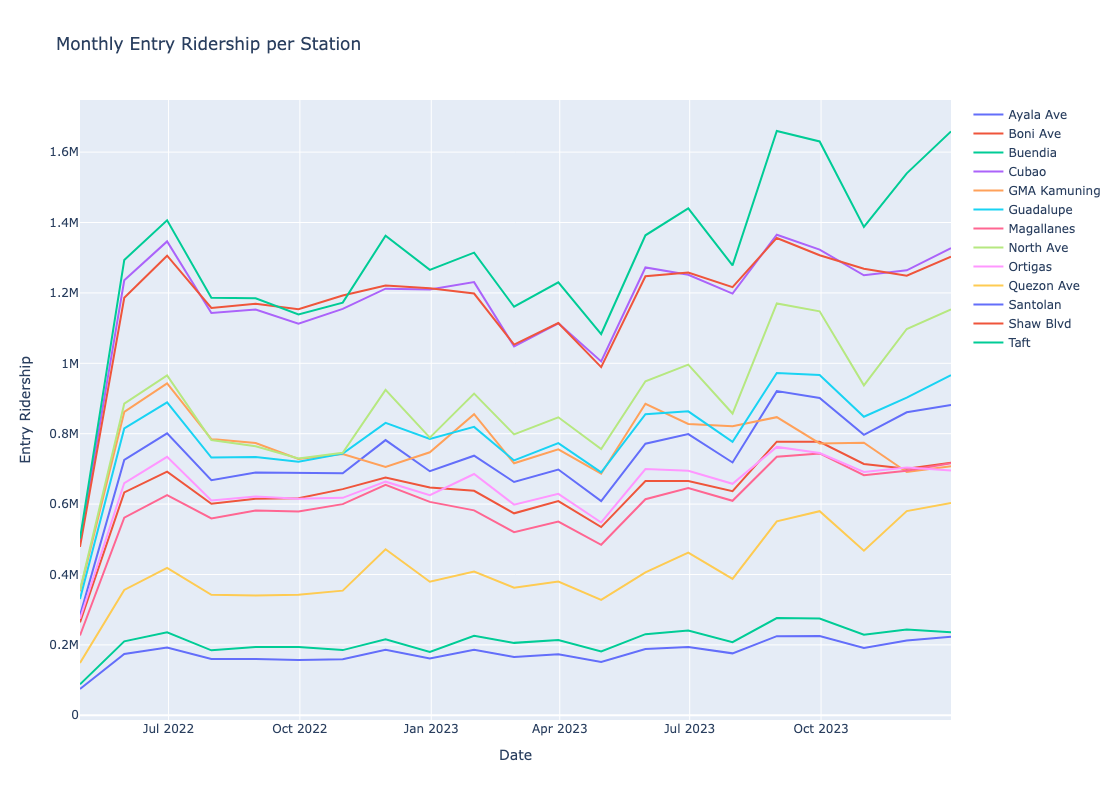

In [64]:
monthly_sums_df = pd.DataFrame()

for station, df in imputed_station_dfs.items():
    monthly_sums = df.resample('ME').sum()
    monthly_sums_df[station] = monthly_sums['Entry']

fig = go.Figure()

for column in monthly_sums_df.columns:
    fig.add_trace(go.Scatter(x=monthly_sums_df.index, y=monthly_sums_df[column], mode='lines', name=column))

fig.update_layout(
    title='Monthly Entry Ridership per Station',
    xaxis_title='Date',
    yaxis_title='Entry Ridership',
    hovermode='x',
    width=1200,  
    height=800   
)

fig.show()

### Boxplots of Ridership per Day

## 3.6 Statistical Analysis

### Correlation Matrix

In [68]:
combined_df = pd.concat(imputed_station_dfs.values(), ignore_index=True)
combined_df = combined_df.drop(columns=['Station_Name'])
combined_df

Entry    Year  Month   Day  Hour  Weekday  Is_Holiday
0         11.0  2023.0    3.0   1.0   4.0      3.0         0.0
1        647.0  2023.0    3.0   1.0   5.0      3.0         0.0
2       1508.0  2023.0    3.0   1.0   6.0      3.0         0.0
3       1531.0  2023.0    3.0   1.0   7.0      3.0         0.0
4       1319.0  2023.0    3.0   1.0   8.0      3.0         0.0
...        ...     ...    ...   ...   ...      ...         ...
161975  2546.4  2023.0    1.0  31.0  19.0      2.0         0.0
161976  2248.6  2023.0    1.0  31.0  20.0      2.0         0.0
161977  1042.6  2023.0    1.0  31.0  21.0      2.0         0.0
161978   630.6  2023.0    1.0  31.0  22.0      2.0         0.0
161979   368.0  2023.0    1.0  31.0  23.0      2.0         0.0

[161980 rows x 7 columns]

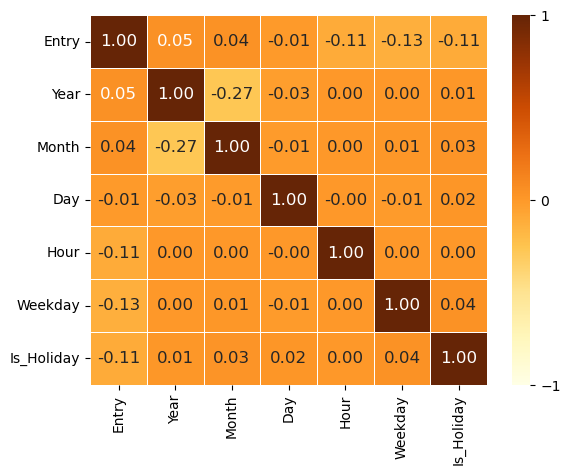

In [69]:
corr_matrix = combined_df[['Entry', 'Year', 'Month','Day', 'Hour', 'Weekday', 'Is_Holiday']].corr()
ax = sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr', vmin=-1, vmax=1,
                     cbar_kws={'ticks': [-1, 0, 1]}, annot_kws={'size': 12}, 
                     fmt='.2f', linewidths=0.5) 

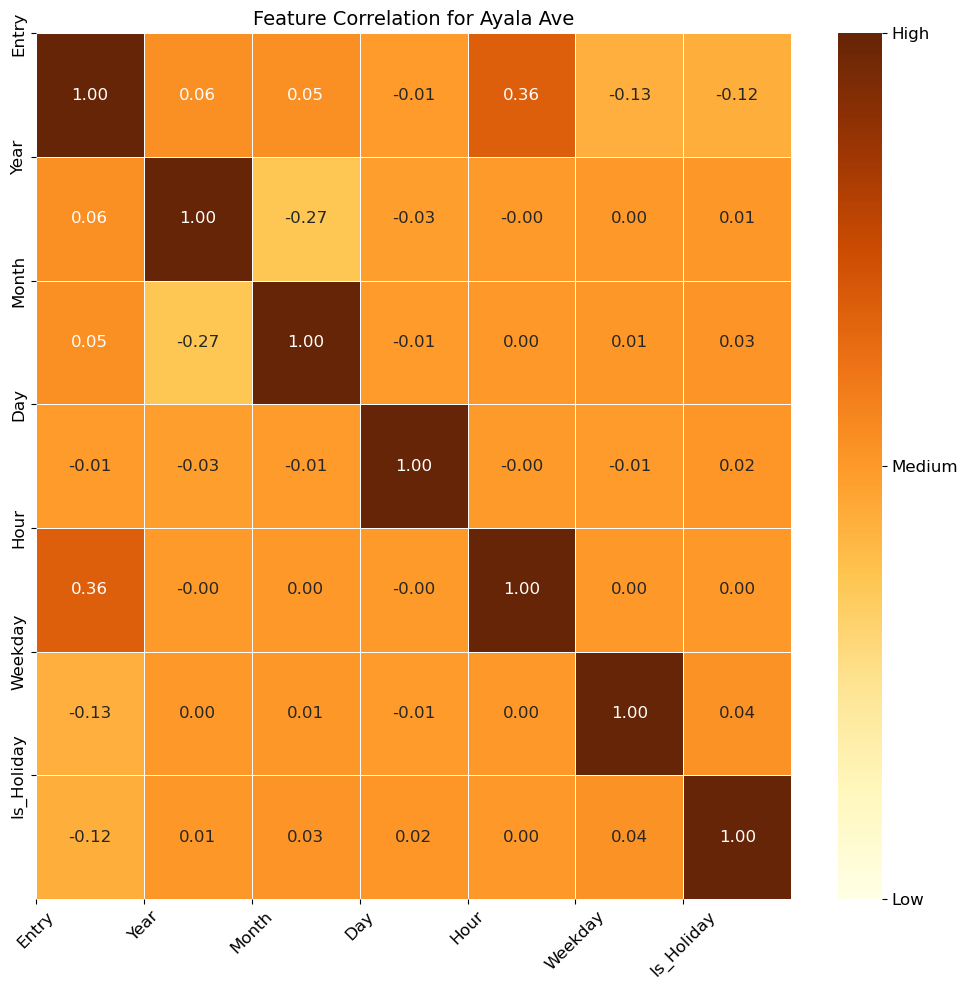

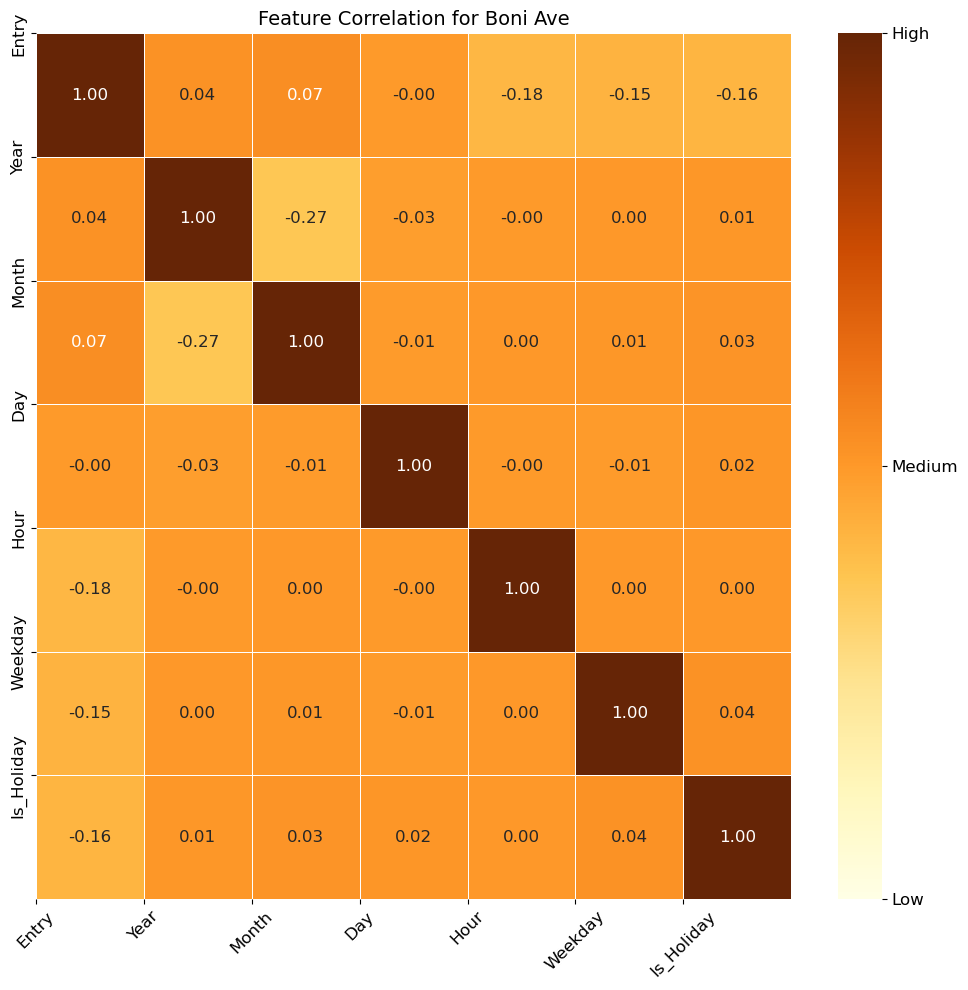

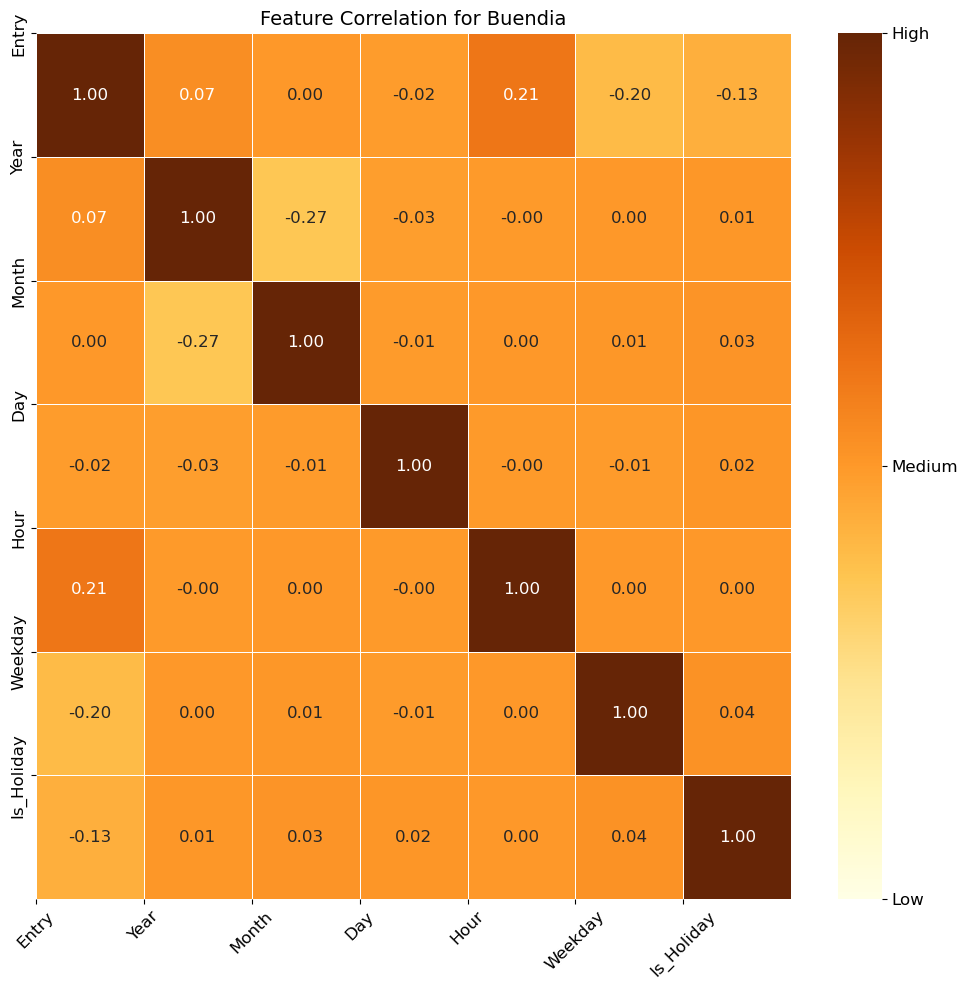

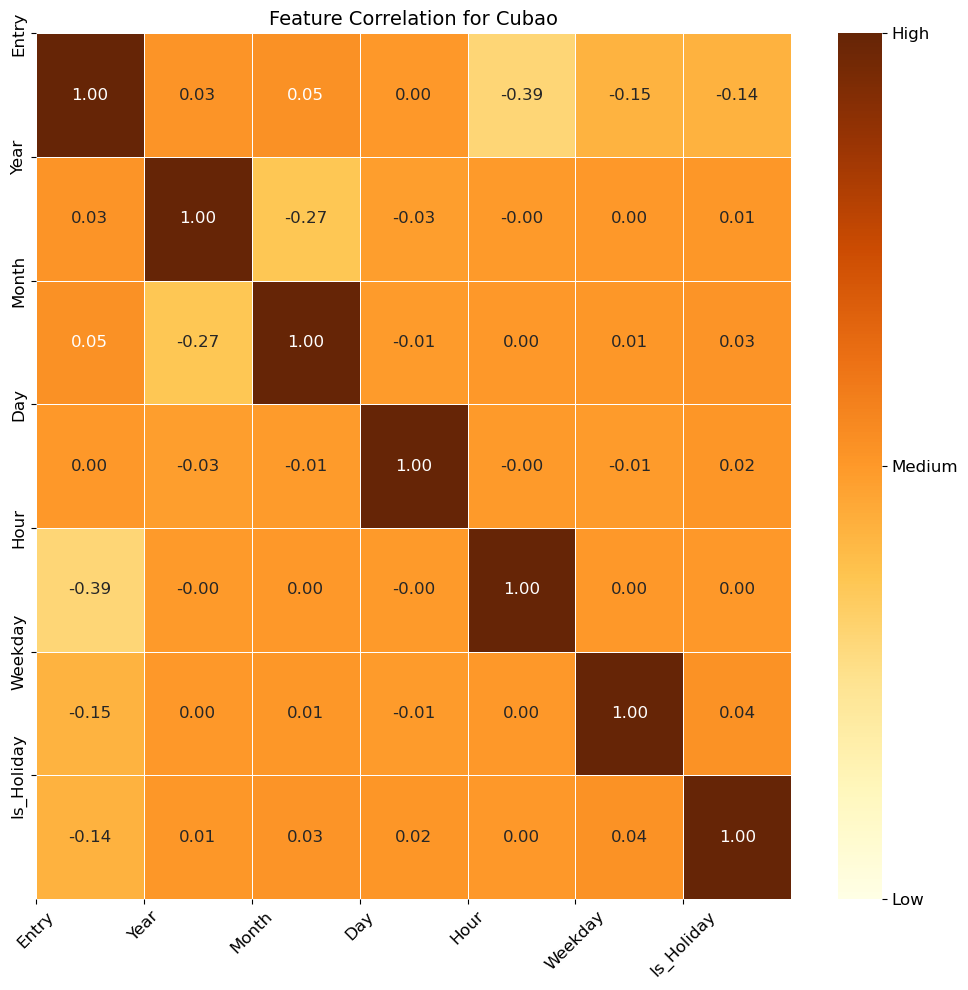

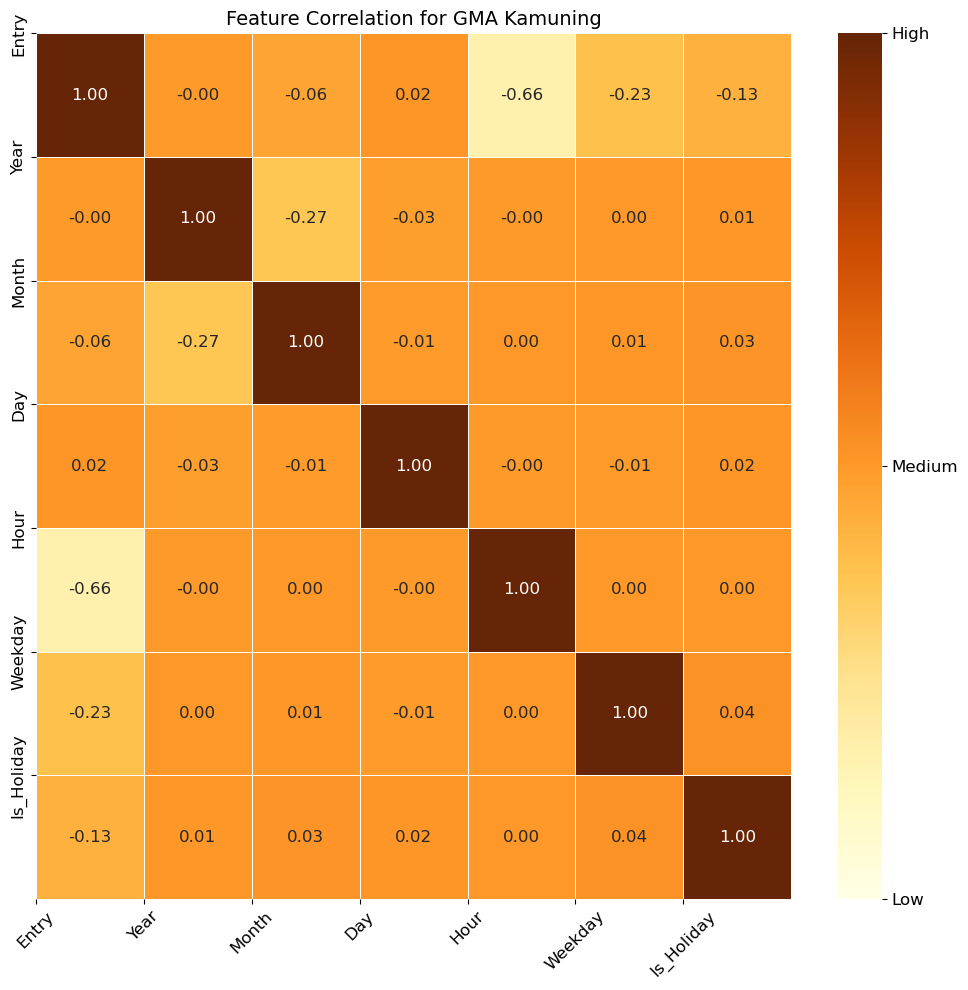

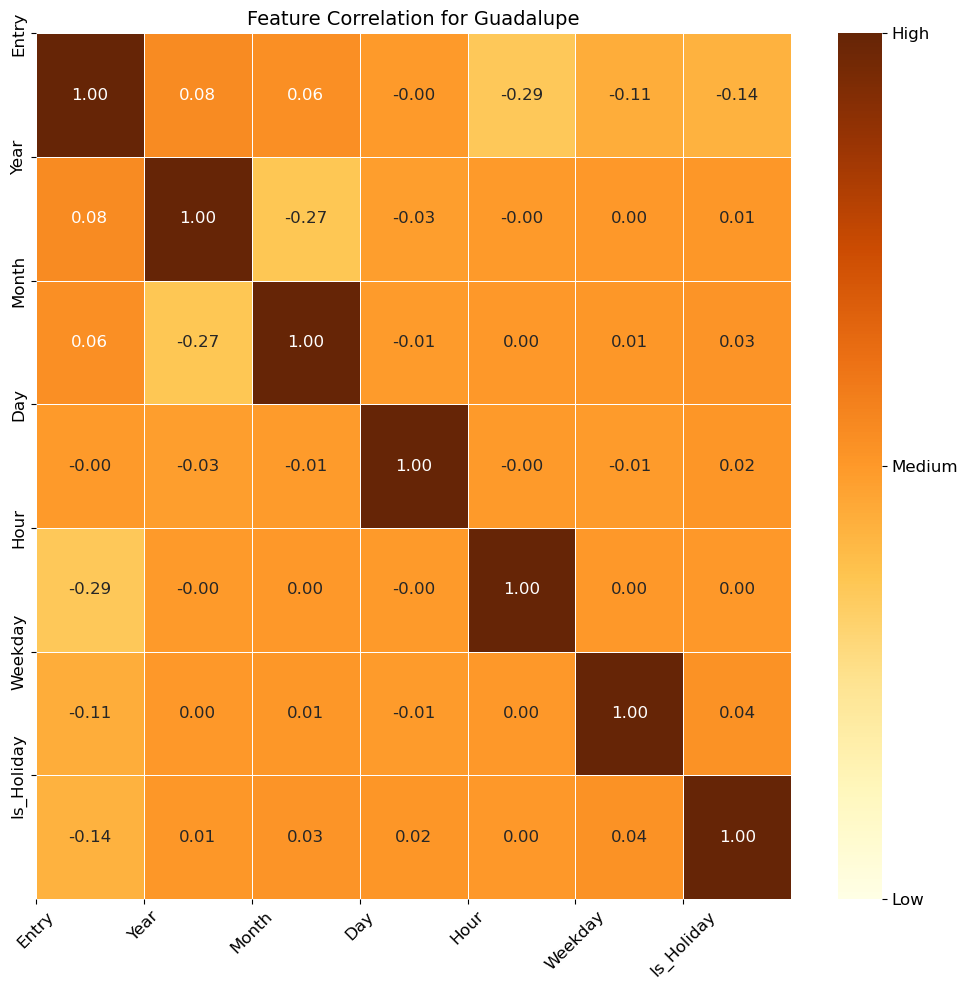

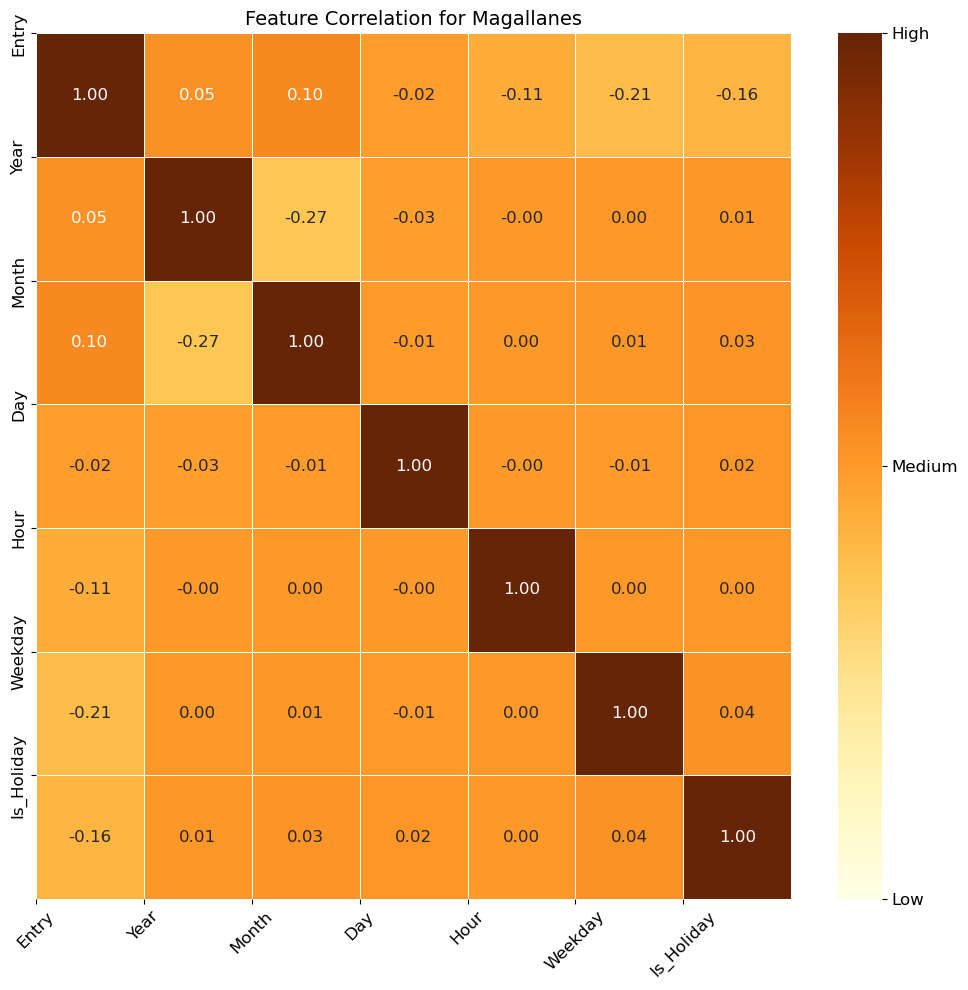

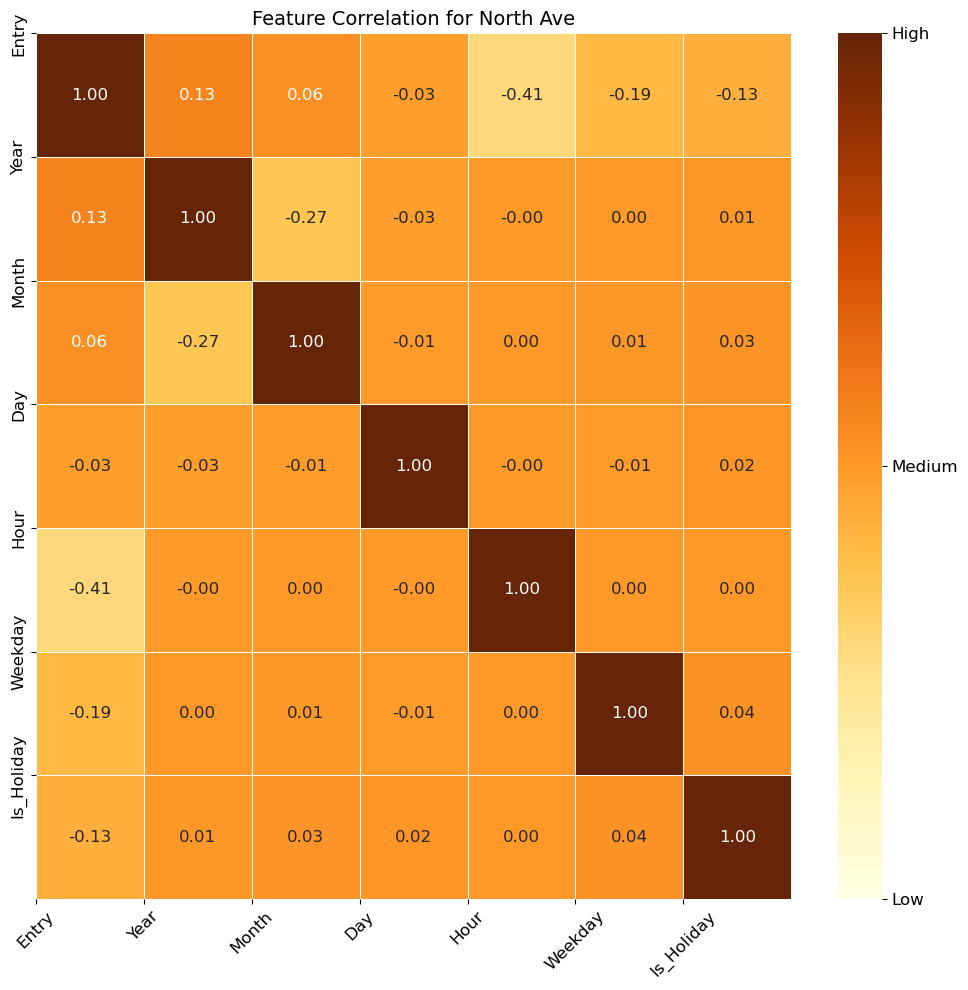

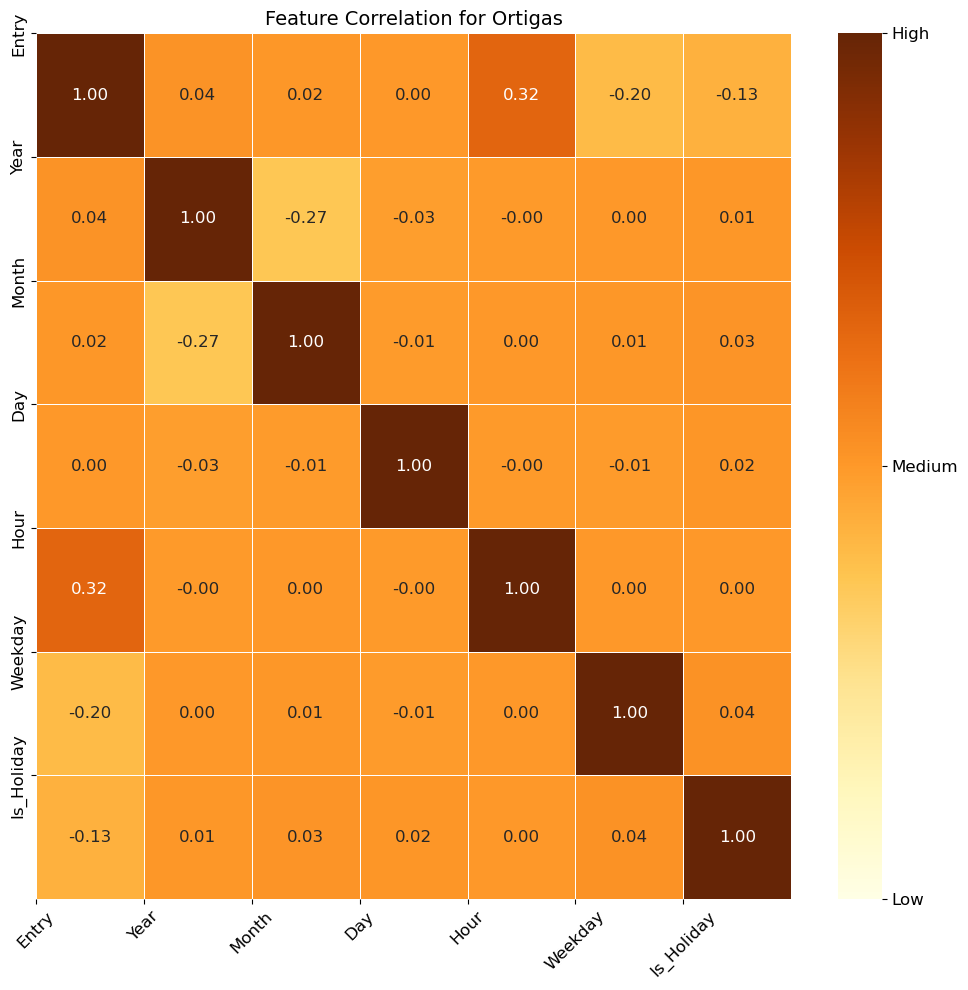

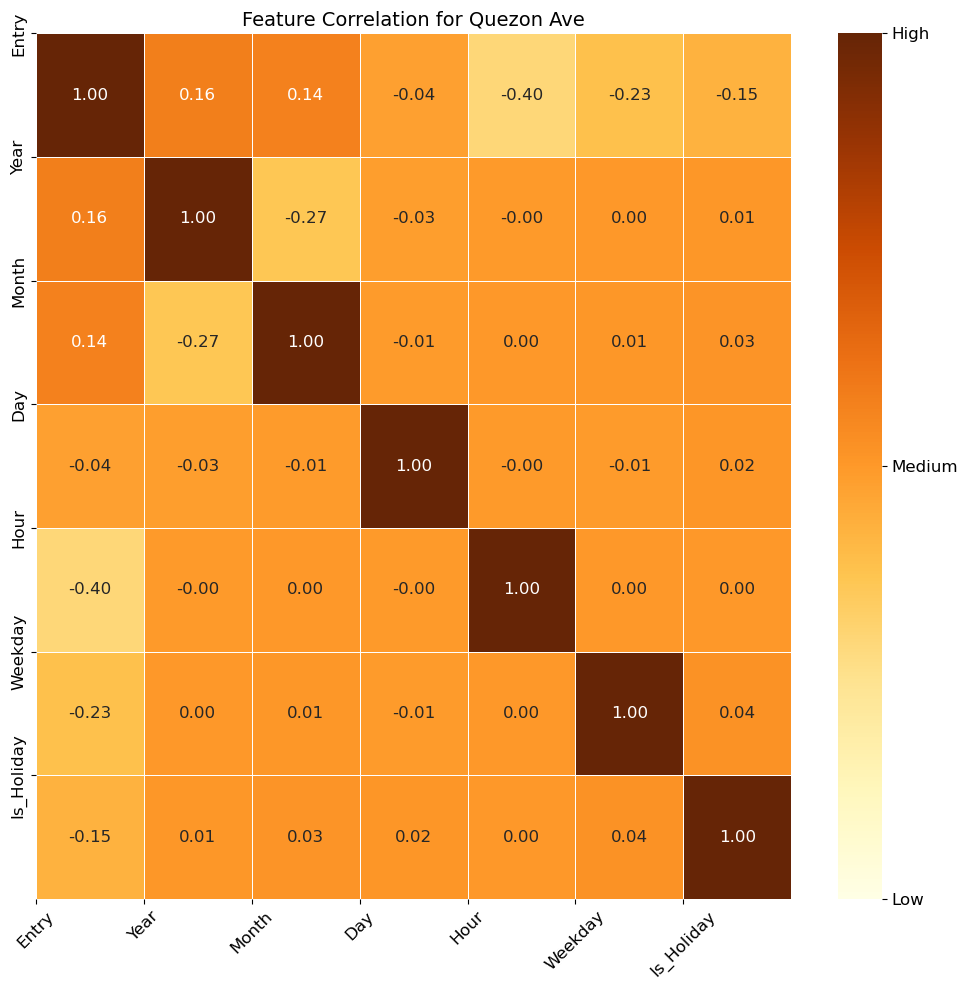

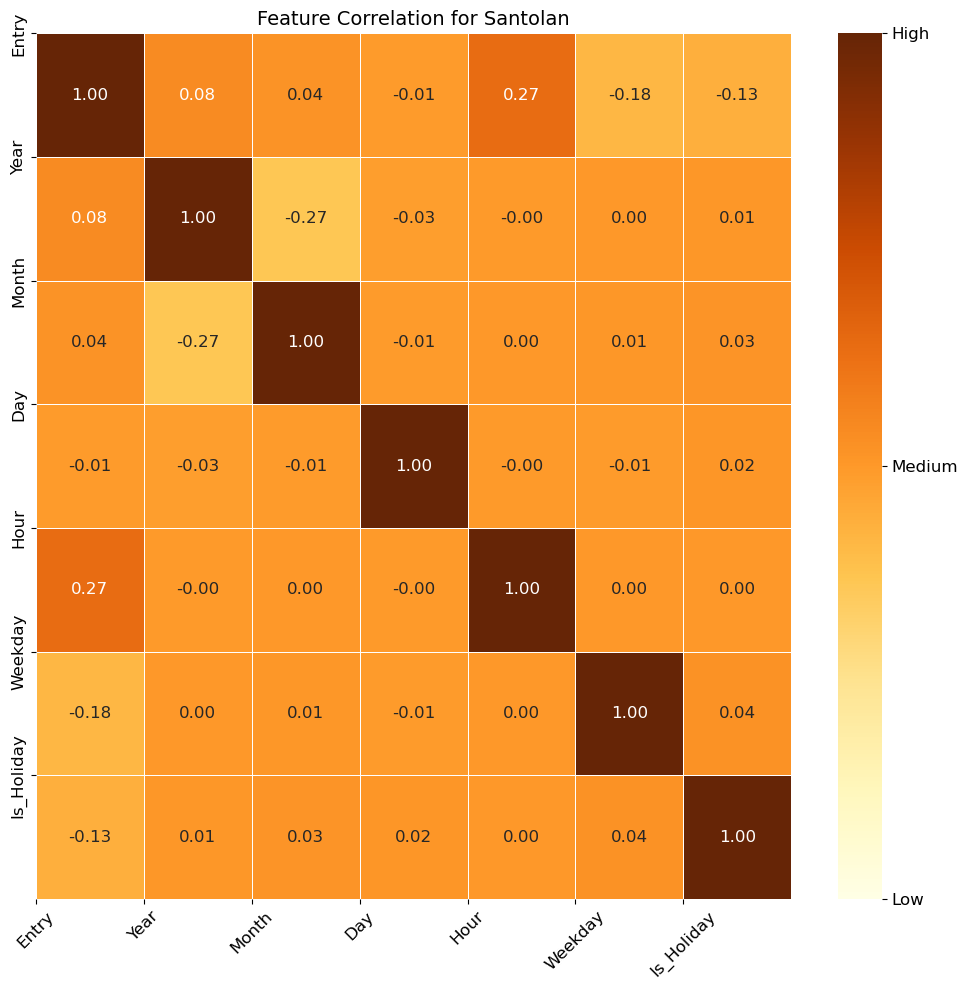

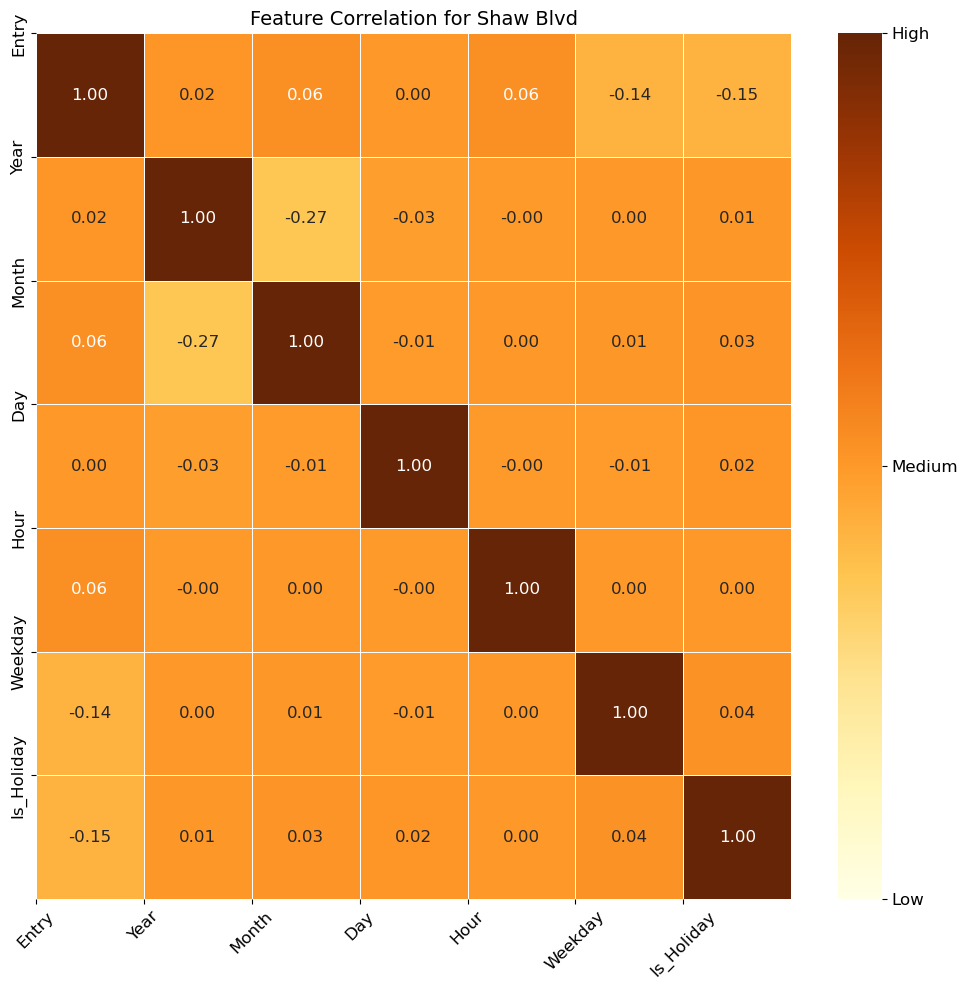

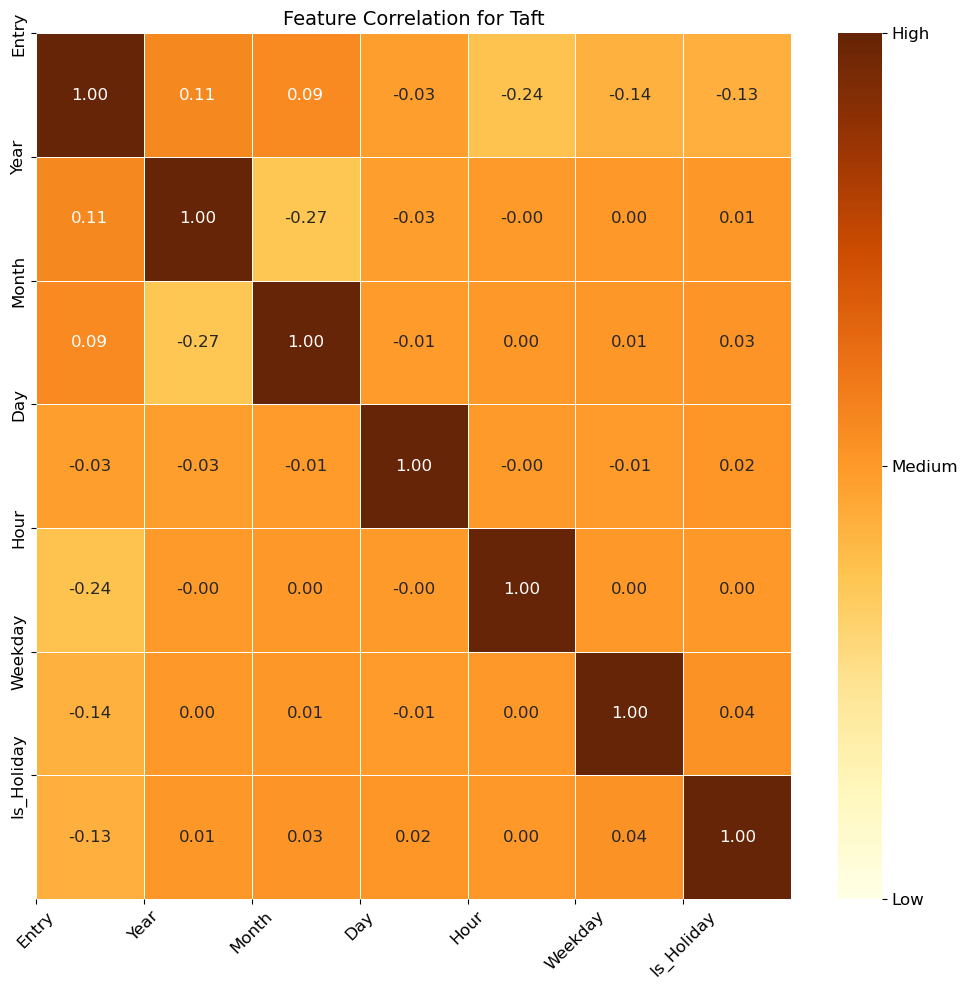

In [70]:
correlation_matrices = {}

for station, df in imputed_station_dfs.items():
    corr_matrix = df[['Entry', 'Year', 'Month','Day', 'Hour', 'Weekday', 'Is_Holiday']].corr()
    correlation_matrices[station] = corr_matrix

for station, corr_matrix in correlation_matrices.items():
    plt.figure(figsize=(10, 10))  # Increase figure size for better readability
    ax = sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr', vmin=-1, vmax=1,
                     cbar_kws={'ticks': [-1, 0, 1]}, annot_kws={'size': 12},  
                     fmt='.2f', linewidths=0.5)  

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(['Low', 'Medium', 'High'])
    cbar.ax.tick_params(labelsize=12) 

    plt.xticks(ticks=range(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=45, fontsize=12)
    plt.yticks(ticks=range(len(corr_matrix.columns)), labels=corr_matrix.columns, fontsize=12)
    plt.title(f'Feature Correlation for {station}', fontsize=14)

    plt.tight_layout()
    plt.show()

### Time Series Decomposition
CANNOT RUN. NEEDS AT LEAST 2 YEARS FOR SEASONALITY.

In [72]:
combined_df['Date'] = pd.to_datetime(combined_df[['Year', 'Month', 'Day']])
combined_df.set_index('Date', inplace=True)

combined_df = combined_df[['Entry']]

monthly_df = combined_df.resample('ME').sum() 
monthly_df

Entry
Date                  
2022-04-30   3872183.0
2022-05-31   9597792.0
2022-06-30  10555177.0
2022-07-31   8910370.0
2022-08-31   8979990.0
2022-09-30   8776440.0
2022-10-31   8996951.0
2022-11-30   9906342.2
2022-12-31   9302644.0
2023-01-31   9794971.6
2023-02-28   8588872.2
2023-03-31   9087155.2
2023-04-30   8046864.4
2023-05-31  10147750.4
2023-06-30  10339451.0
2023-07-31   9540944.8
2023-08-31  11618005.0
2023-09-30  11394480.0
2023-10-31  10238209.2
2023-11-30  10739427.4
2023-12-31  11189372.0

# <span style="color:blue"> IV. Model Training with Hyperparameter Tuning </span>

## 4.1 Model Preparation

In [75]:
df_names = [north_ave_df, quezon_ave_df, gma_kamuning_df, cubao_df,
    santolan_df, ortigas_df, shaw_blvd_df, boni_ave_df,
    guadalupe_df, buendia_df, ayala_ave_df, magallanes_df, taft_df]

In [76]:
split_ratio = 0.7
split_index = int(len(df_names[0]) * split_ratio)
split_index

8722

In [90]:
train_sets = []
test_sets = []

for each in df_names:
    each.index = pd.to_datetime(each.index)
    train_set = each.iloc[:8722]
    test_set = each.iloc[8722:]
    
    df_name = [name for name in globals() if globals()[name] is each][0]
    train_set_name = f'train_{df_name}'
    test_set_name = f'test_{df_name}'
    
    exec(f'{train_set_name} = train_set')
    exec(f'{test_set_name} = test_set')

    train_sets.append(train_set)
    test_sets.append(test_set)
    
    print(f'{train_set_name}: {globals()[train_set_name].shape}')
    print(f'{test_set_name}: {globals()[test_set_name].shape}')

train_north_ave_df: (8722, 8)
test_north_ave_df: (3738, 8)
train_quezon_ave_df: (8722, 8)
test_quezon_ave_df: (3738, 8)
train_gma_kamuning_df: (8722, 8)
test_gma_kamuning_df: (3738, 8)
train_cubao_df: (8722, 8)
test_cubao_df: (3738, 8)
train_santolan_df: (8722, 8)
test_santolan_df: (3738, 8)
train_ortigas_df: (8722, 8)
test_ortigas_df: (3738, 8)
train_shaw_blvd_df: (8722, 8)
test_shaw_blvd_df: (3738, 8)
train_boni_ave_df: (8722, 8)
test_boni_ave_df: (3738, 8)
train_guadalupe_df: (8722, 8)
test_guadalupe_df: (3738, 8)
train_buendia_df: (8722, 8)
test_buendia_df: (3738, 8)
train_ayala_ave_df: (8722, 8)
test_ayala_ave_df: (3738, 8)
train_magallanes_df: (8722, 8)
test_magallanes_df: (3738, 8)
train_df: (8722, 8)
test_df: (3738, 8)


## 4.2 Model Creation

#### 4.2.1 Gradient Boosting

In [108]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

results = []

for train in train_sets:
    X_train = train.drop(columns=['Entry','Station_Name'])  
    y_train = train['Entry'] 

    gbr = GradientBoostingRegressor()
    grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    results.append({
        'train_set_name': [key for key in globals() if globals()[key] is train][0],
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_  # Convert negative MSE to positive
    })

    # Print results
    print(f"Train set: {results[-1]['train_set_name']}")
    print(f"Best Parameters: {results[-1]['best_params']}")
    print(f"Best Score (MSE): {results[-1]['best_score']}")
    print()

results_df = pd.DataFrame(results)
results

Train set: train_north_ave_df
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Score (MSE): 150204.23610416363

Train set: train_quezon_ave_df
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}
Best Score (MSE): 41056.04464793998

Train set: train_gma_kamuning_df
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}
Best Score (MSE): 72572.9443451254

Train set: train_cubao_df
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}
Best Score (MSE): 131989.66338851664

Train set: train_santolan_df
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Best Score (MSE): 7387.123461935762

Train set: train_ortigas_df
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Best Score (MSE): 69041.70849759833

Train set: train_shaw_blvd_df
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Best Score (MSE): 148341.258109333

[{'train_set_name': 'train_north_ave_df',
  'best_params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100},
  'best_score': 150204.23610416363},
 {'train_set_name': 'train_quezon_ave_df',
  'best_params': {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150},
  'best_score': 41056.04464793998},
 {'train_set_name': 'train_gma_kamuning_df',
  'best_params': {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150},
  'best_score': 72572.9443451254},
 {'train_set_name': 'train_cubao_df',
  'best_params': {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150},
  'best_score': 131989.66338851664},
 {'train_set_name': 'train_santolan_df',
  'best_params': {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50},
  'best_score': 7387.123461935762},
 {'train_set_name': 'train_ortigas_df',
  'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50},
  'best_score': 69041.70849759833},
 {'train_set_name': 'train_shaw_blvd_df',
  'best_params': {'learnin

#### 4.2.2 Polynomial Regression Method

#### 4.2.3 Auto-Regressive Integrated Moving Average (ARIMA)  

# <span style="color:blue"> Summary of Best Model Configuration and Model Metrics </span>

In [189]:
# Median Absolute Error (MedAE)
# Median Absolute Percentage Error (MdPAE) 

# <span style="color:blue"> Summary of Findings and Recommendations </span>

# <span style="color:blue"> References </span>